# Training and Running of new GLM model
This Notebook is for training and running the our new GLM model that includes (for now only) deletion tokens

## Adding necessary imports
You can run this block to import necessary classes and functions

Checking for existing trained model in ./dna_bert_final_indel
Loading tokenizer...
Tokenizer loaded
Loading dataset...
Dataset loaded
Loading model...
Model loaded successfully!
Model type: With deletions
Trained for 500 epochs
Final validation loss: 1.1700
Training curves saved to ./dna_bert_final_indel/training_curves_replotted.png


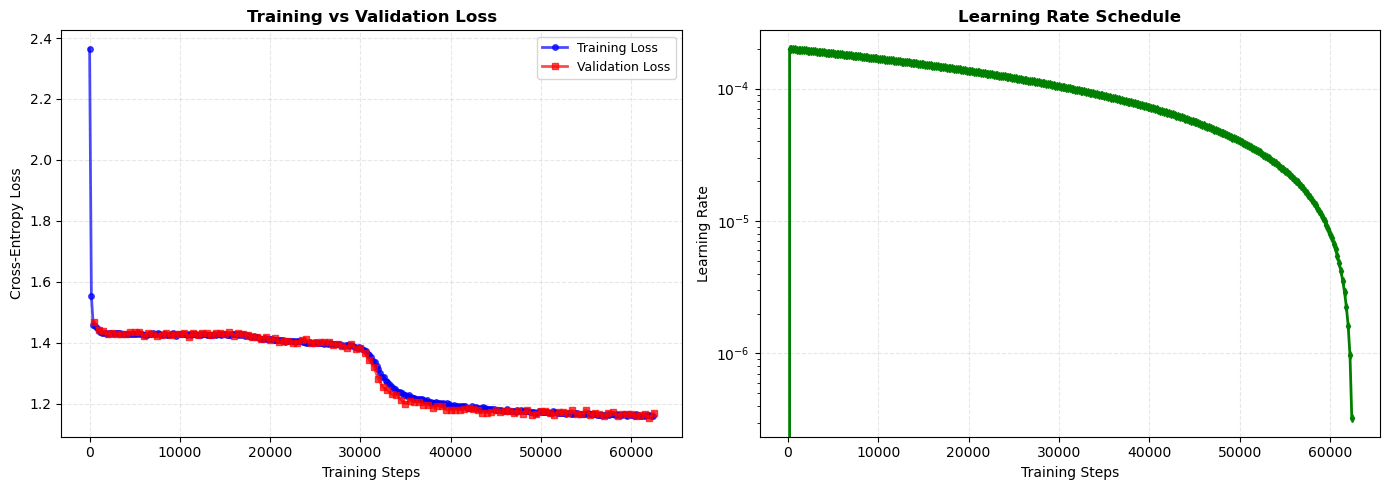


Training Summary:
Final training loss: 1.1581
Final validation loss: 1.1700
Best validation loss: 1.1523
Checking for existing trained model in ./dna_bert_final_baseline
Loading tokenizer...
Tokenizer loaded
Loading dataset...
Dataset loaded
Loading model...
Model loaded successfully!
Model type: Baseline (no deletions)
Trained for 500 epochs
Final validation loss: 1.0593
Training curves saved to ./dna_bert_final_baseline/training_curves_replotted.png


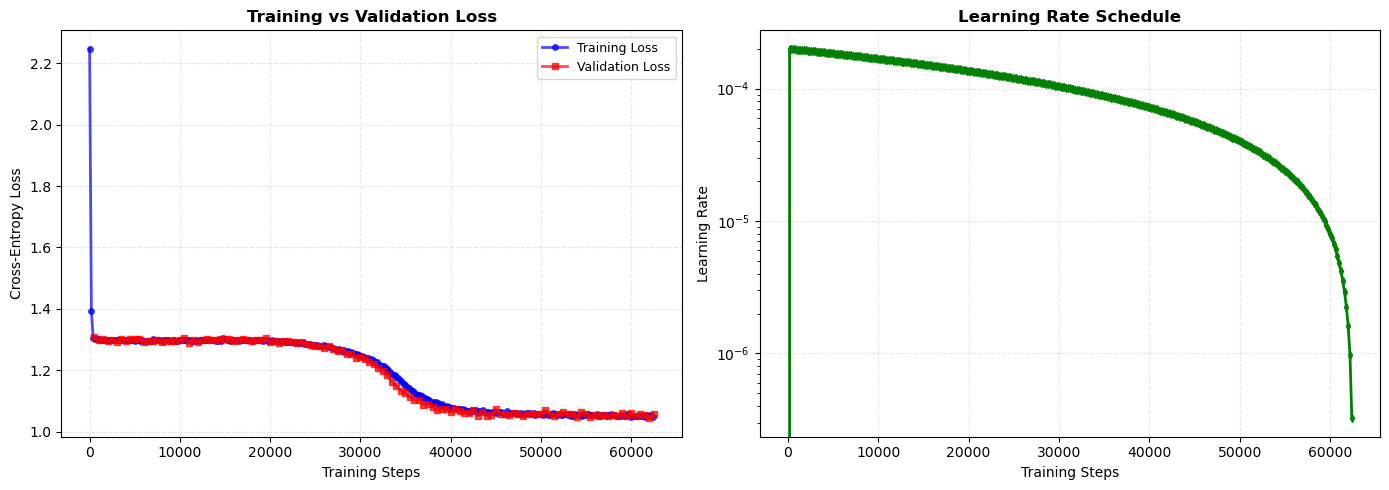


Training Summary:
Final training loss: 1.0492
Final validation loss: 1.0593
Best validation loss: 1.0441


In [1]:
from fundemental_classes.model_related.glm_model import GLMModel

# You can change force_retrain to True if you want to always retrain your model everytime
deletion_model = GLMModel("./dna_bert_final_indel",
                          "simulated_sequences_distance=5/new_augumented_sequence_size5000_length100_deletions0.2_nodeletionseq0.05.fasta",
                          force_retrain=False, include_deletions=True)
baseline_model = GLMModel("./dna_bert_final_baseline",
                           "simulated_baseline_sequences_distance=5/new_augumented_sequence_size5000_length150_deletions0_nodeletionseq0.05.fasta",
                           force_retrain=False, include_deletions=False)

# Set the default Model to train and use for visualization
model = deletion_model
use_deletions = True


## Training
We use `Bert` model to create the embeddings and train it using masking to get nicely trained model. If you want to change the size of training data, please look into `simulated_sequences` directory. \\\

Below is given two subheaders: *Baseline Model Training & Deletion Model Training*. Each of them can be run seperately if you are looking for seperate results or loading.
*important:* Training is not necessary if you already have a trained model. You can load it using the `GLMModel`.

### Baseline Model Training

PyTorch: setting up devices
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
average_tokens_across_devices is True but world size is 1. Setting it to False automatically.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Dataset split: 4000 training, 1000 validation
Model type: Baseline (no deletions)
Vocabulary: ['A', 'C', 'G', 'T']
Starting Training


***** Running training *****
  Num examples = 4,000
  Num Epochs = 500
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 62,500
  Number of trainable parameters = 8,619,785


Step,Training Loss,Validation Loss
500,1.305700,1.301205
1000,1.303800,1.300091
1500,1.302200,1.301226
2000,1.299400,1.294018
2500,1.301500,1.301156
3000,1.300900,1.297885
3500,1.299600,1.300711
4000,1.300000,1.298166
4500,1.300300,1.304457
5000,1.299200,1.305109



***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to ./dna_bert_final_baseline/checkpoint-500
Configuration saved in ./dna_bert_final_baseline/checkpoint-500/config.json
Model weights saved in ./dna_bert_final_baseline/checkpoint-500/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_bert_final_baseline/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./dna_bert_final_baseline/checkpoint-500/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to ./dna_bert_final_baseline/checkpoint-1000
Configuration saved in ./dna_bert_final_baseline/checkpoint-1000/config.json
Model weights saved in ./dna_bert_final_baseline/checkpoint-1000/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_

Saving model and tokenizer...
Training complete
Metadata saved to ./dna_bert_final_baseline/training_metadata.json
Training curves saved to ./dna_bert_final_baseline/training_curves.png


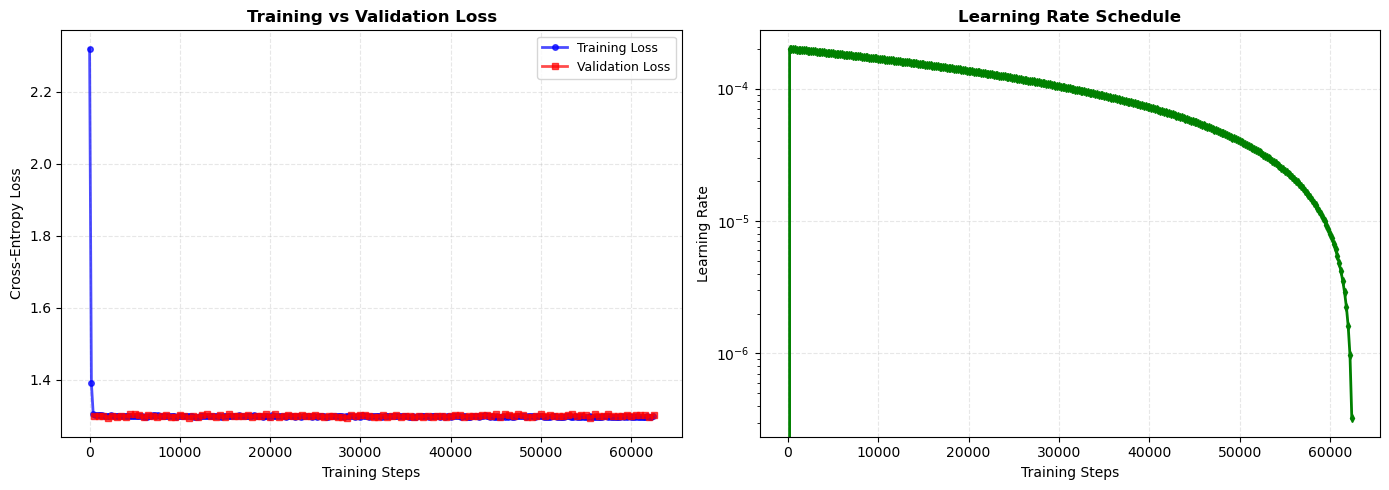


Training Summary:
Final training loss: 1.2990
Final validation loss: 1.3029
Best validation loss: 1.2936
Training history saved to ./dna_bert_final_baseline/training_history.json


In [5]:
baseline_model.train(epochs=500, batch_size=32, lr=2e-4)

### Deletion Model Training

Dataset split: 4000 training, 1000 validation
Model type: With deletions
Vocabulary: ['A', 'C', 'G', 'T', '-']


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
***** Running training *****
  Num examples = 4,000
  Num Epochs = 500
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 62,500
  Number of trainable parameters = 8,620,042


Starting Training


Step,Training Loss,Validation Loss
500,1.458400,1.469576
1000,1.442900,1.440998
1500,1.433000,1.437392
2000,1.429900,1.428803
2500,1.432100,1.432684
3000,1.432500,1.428311
3500,1.430500,1.428096
4000,1.428300,1.427211
4500,1.430200,1.434554
5000,1.429500,1.435561



***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to ./dna_bert_final_indel/checkpoint-500
Configuration saved in ./dna_bert_final_indel/checkpoint-500/config.json
Model weights saved in ./dna_bert_final_indel/checkpoint-500/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_bert_final_indel/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./dna_bert_final_indel/checkpoint-500/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to ./dna_bert_final_indel/checkpoint-1000
Configuration saved in ./dna_bert_final_indel/checkpoint-1000/config.json
Model weights saved in ./dna_bert_final_indel/checkpoint-1000/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_bert_final_indel/checkpo

Saving model and tokenizer...


Model weights saved in ./dna_bert_final_indel/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_bert_final_indel/tokenizer_config.json
Special tokens file saved in ./dna_bert_final_indel/special_tokens_map.json
tokenizer config file saved in ./dna_bert_final_indel/tokenizer_config.json
Special tokens file saved in ./dna_bert_final_indel/special_tokens_map.json


Training complete
Metadata saved to ./dna_bert_final_indel/training_metadata.json
Training curves saved to ./dna_bert_final_indel/training_curves.png


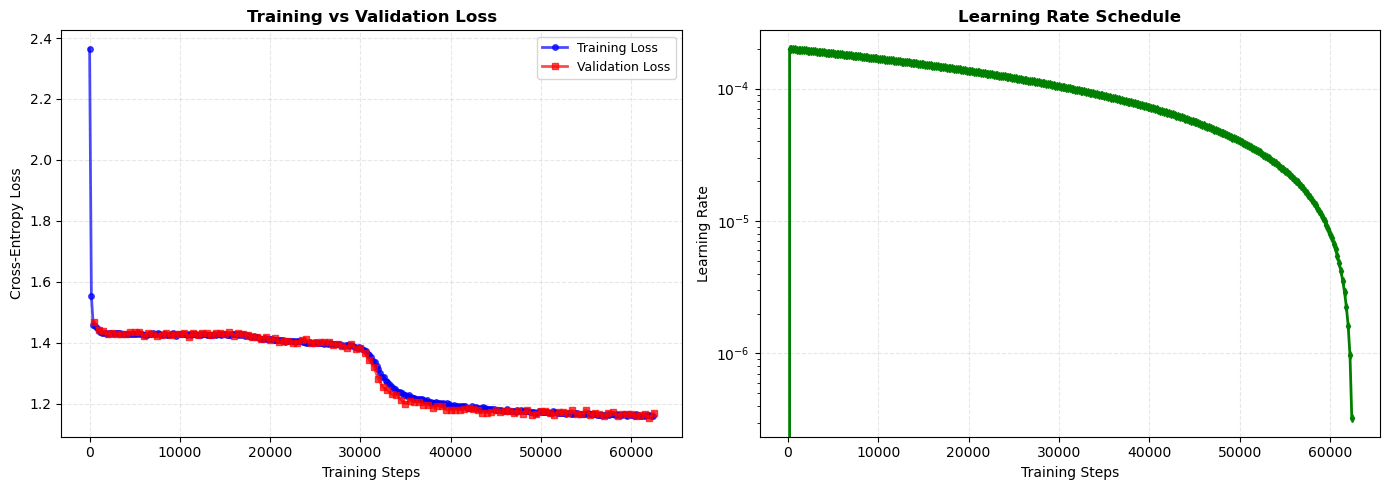


Training Summary:
Final training loss: 1.1581
Final validation loss: 1.1700
Best validation loss: 1.1523
Training history saved to ./dna_bert_final_indel/training_history.json


In [3]:
deletion_model.train(epochs=500, batch_size=32, lr=2e-4)


## Visualization | Sequence reconstruction probabilities
This block is used for getting already trained model, passing the sequence to test how well the model performs.
\\\\\
*Important:* For now we pass our test cases by hand. However in the future we will generate good inputs to test how well the model functions

### OLD SEQUENCE PLOTTER

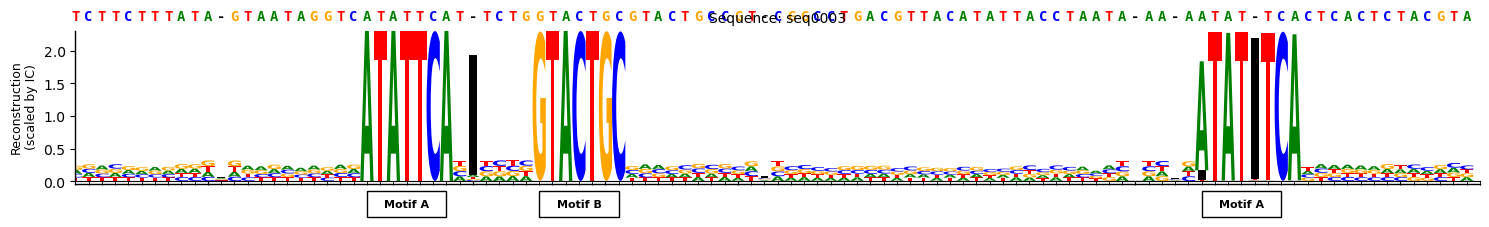

In [3]:
from fundemental_classes.visualization.sequence_plotter import plot

#normal reconstruction
header = "seq0003|label=both|posAmotif=22,85|posBmotif=35|gaplength=5|deletions=6"
sequence = "TCTTCTTTATA-GTAATAGGTCATATTCAT-TCTGGTACTGCGTACTGCCGT-CGGCCTGACGTTACATATTACCTAATA-AA-AATAT-TCACTCACTCTACGTA"

prob_matrix = deletion_model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=6, with_deletions=True)

/data/ceph/hdd/project/node_09/sys_gen_students/2025_2026/p06_better_indel_glm/Sysgen-GLM-for-Indels/fundemental_classes/visualization/sequence_plotter_new.py:100: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


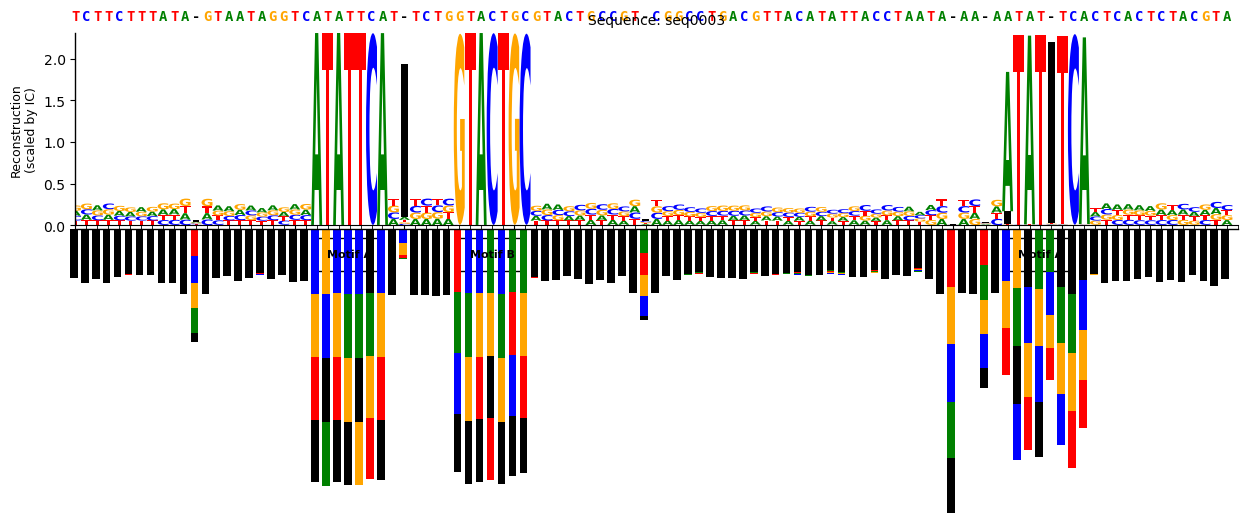

In [4]:
# plotter with negative values
from fundemental_classes.visualization.sequence_plotter_new import plot

#normal reconstruction
header = "seq0003|label=both|posAmotif=22,85|posBmotif=35|gaplength=5|deletions=6"
sequence = "TCTTCTTTATA-GTAATAGGTCATATTCAT-TCTGGTACTGCGTACTGCCGT-CGGCCTGACGTTACATATTACCTAATA-AA-AATAT-TCACTCACTCTACGTA"

prob_matrix = deletion_model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=6, with_deletions=True)

## Baseline model reconstruction

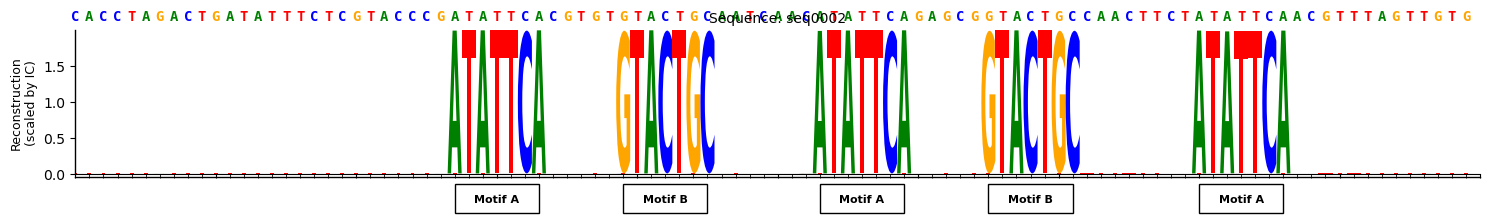

In [5]:
from fundemental_classes.visualization.sequence_plotter import plot

#normal reconstruction

header = "seq0002|label=both|posAmotif=27,53,80|posBmotif=39,65|gaplength=5|deletions=0"
sequence = "CACCTAGACTGATATTTCTCGTACCCGATATTCACGTGTGTACTGCAATCAACATATTCAGAGCGGTACTGCCAACTTCTATATTCAACGTTTAGTTGTG"

prob_matrix = baseline_model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=6, with_deletions=False)

/data/ceph/hdd/project/node_09/sys_gen_students/2025_2026/p06_better_indel_glm/Sysgen-GLM-for-Indels/fundemental_classes/visualization/sequence_plotter_new.py:100: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


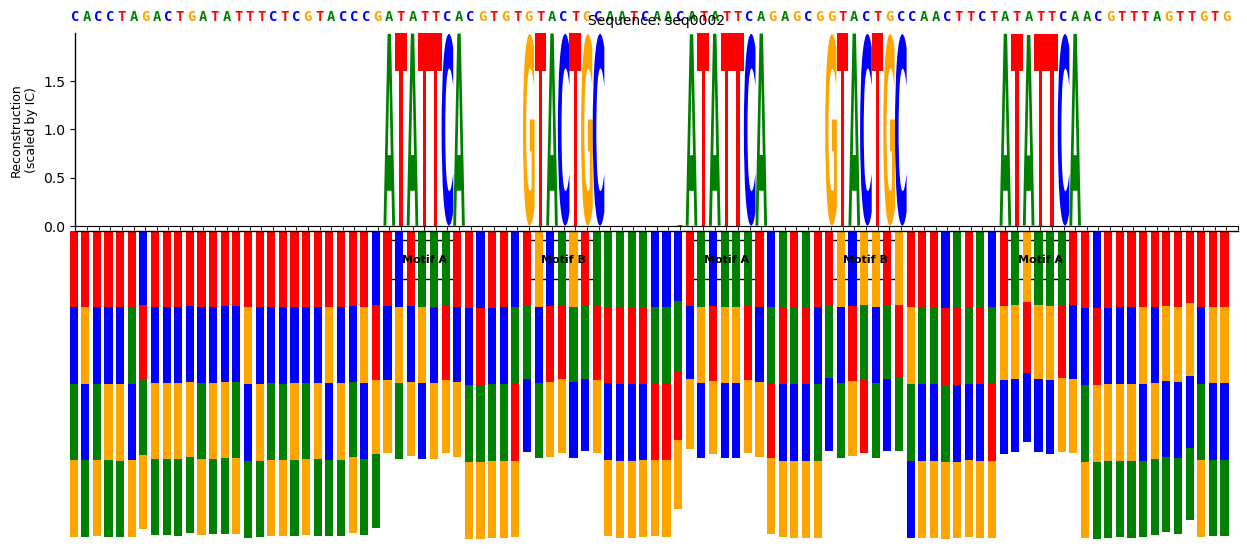

In [6]:
from fundemental_classes.visualization.sequence_plotter_new import plot

#normal reconstruction - indel model
header = "seq0002|label=both|posAmotif=27,53,80|posBmotif=39,65|gaplength=5|deletions=0"
sequence = "CACCTAGACTGATATTTCTCGTACCCGATATTCACGTGTGTACTGCAATCAACATATTCAGAGCGGTACTGCCAACTTCTATATTCAACGTTTAGTTGTG"

prob_matrix = baseline_model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=6, with_deletions=False)

## Visualization | Dependency Map
This block is used for getting already trained model, passing the sequence to test how well the model performs.
\\\\\

In [7]:
from fundemental_classes.visualization.heat_map_plotter import DependencyMapGenerator
import numpy as np
import plotly.graph_objects as go
from fundemental_classes.visualization.sequence_logo import SequenceLogo


def depencency_map_with_logo(
    model,
    sequence,
    type='snp',
    use_deletions=True,
    cap=None,              # for saturation
):
    dep_gen = DependencyMapGenerator(model, type=type, use_deletions=use_deletions)

    prob_matrix = model.get_full_reconstruction_probs(sequence)
    dep_map = dep_gen.analyze(sequence, show_plot=False)

    if cap is not None:
        cap = float(cap)
        dep_map = np.clip(dep_map, -cap, cap)

    L = dep_map.shape[0]
    reconstruction_logo = SequenceLogo.from_reconstruction(prob_matrix)

    fig = go.Figure()
    fig.add_trace(
        go.Heatmap(
            z=dep_map,
            x=np.arange(L),
            y=np.arange(L),
            colorscale="RdBu_r",
            zmax=cap if cap is not None else None
        )
    )

    fig.update_xaxes(visible=True, scaleanchor="y", constrain="domain")
    fig.update_yaxes(visible=True, autorange="reversed", scaleanchor="x", constrain="domain")

    fig.add_layout_image(
        source=reconstruction_logo.to_svg(data_url=True),
        xref="x",
        yref="y domain",
        x=-0.5,
        y=1.0,
        sizex=L,
        sizey=0.10,
        xanchor="left",
        yanchor="bottom",
        sizing="stretch",
    )

    fig.update_layout(
        width=900,
        height=900,
        margin=dict(l=20, r=20, t=100, b=20),
    )

    fig.show()
        


In [13]:
#dependency map for snp 
header = "seq0003|label=both|posAmotif=22,85|posBmotif=35,42|gaplength=5|deletions=6"
sequence = "TCTTCTTTATA-GTAATAGGTCATATTCAT-TCTGGTACTGCGTACTGCCGT-CGGCCTGACGTTACATATTACCTAATA-AA-AATAT-TCACTCACTCTACGTA"

dep_map = depencency_map_with_logo(model, sequence, type='snp', use_deletions=True, cap = 3)

Computing dependency map...


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

In [5]:
#dependency map for indels - reconstruction

header = "seq0003|label=both|posAmotif=22,85|posBmotif=35,42|gaplength=5|deletions=6"
sequence = "TCTTCTTTATA-GTAATAGGTCATATTCAT-TCTGGTACTGCGTACTGCCGT-CGGCCTGACGTTACATATTACCTAATA-AA-AATAT-TCACTCACTCTACGTA"

dep_map = depencency_map_with_logo(model, sequence, type='indel', use_deletions=True)

Computing dependency map...


Map:   0%|          | 0/101 [00:00<?, ? examples/s]

In [4]:
#dependency map for removing nucleotide

header = "seq0003|label=both|posAmotif=22,85|posBmotif=35,42|gaplength=5|deletions=6"
sequence = "TCTTCTTTATA-GTAATAGGTCATATTCAT-TCTGGTACTGCGTACTGCCGT-CGGCCTGACGTTACATATTACCTAATA-AA-AATAT-TCACTCACTCTACGTA"

dep_map = depencency_map_with_logo(model, sequence, type='removal', use_deletions=True)

Computing dependency map...


Map:   0%|          | 0/107 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

aligned deletion pos: 0 shape: (106, 5)


## baseline model dependency map

In [4]:
#dependency map for removing nucleotide


header = "seq0003|label=both|posAmotif=21,80|posBmotif=33,40|gaplength=5|deletions=0"
sequence = "TCTTCTTTATAGTAATAGGTCATATTCATTCTGGTACTGCGTACTGCCGTCGGCCTGACGTTACATATTACCTAATAAAAATATTCACTCACTCTACGTA"

dep_map = depencency_map_with_logo(baseline_model, sequence, type='snp', use_deletions=False)

Computing dependency map...


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

In [5]:
#dependency map for removing nucleotide

header = "seq0003|label=both|posAmotif=21,80|posBmotif=33,40|gaplength=5|deletions=0"
sequence = "TCTTCTTTATAGTAATAGGTCATATTCATTCTGGTACTGCGTACTGCCGTCGGCCTGACGTTACATATTACCTAATAAAAATATTCACTCACTCTACGTA"

dep_map = depencency_map_with_logo(baseline_model, sequence, type='removal', use_deletions=False)

Computing dependency map...


Map:   0%|          | 0/101 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

aligned deletion pos: 0 shape: (100, 4)
